## **Rajaram Jagadeeswaran: x22239243 - STROKE PREDICTION MODEL**

# ***1. Importing the required Python Library***

In [84]:
import sagemaker
import boto3
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sagemaker.inputs import TrainingInput
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.estimator import Estimator
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from io import StringIO
from imblearn.over_sampling import SMOTE

In [51]:
region = boto3.Session().region_name
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

In [52]:
print(f"AWS Region: {region}")
print(f"RoleArn: {role}")

AWS Region: us-west-2
RoleArn: arn:aws:iam::533267211033:role/service-role/AmazonSageMaker-ExecutionRole-20240728T224074


# ***2. Let's Look at the dataset Stored in S3 utilized by its name***


*   Stoke_prediction_dataset.csv is the dataset file taken from kaggle and used in this model, its a critical patient dataset.

*   The dataset management is managed by AWS S3 Bucket on cloud.



In [53]:
# Stored data Bucket name & file name
bucket_name = 'x22239243-spm'
file_key = 'stroke_prediction_dataset.csv'

In [54]:
# Read the CSV file from S3
s3 = boto3.client('s3')
csv_obj = s3.get_object(Bucket=bucket_name, Key=file_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')

In [55]:
# Load the dataset into a pandas dataframe
data = pd.read_csv(StringIO(csv_string))

In [56]:
data

,Patient ID,Patient Name,Age,Gender,Hypertension,Heart Disease,Marital Status,Work Type,Residence Type,Average Glucose Level,...,Alcohol Intake,Physical Activity,Stroke History,Family History of Stroke,Dietary Habits,Stress Levels,Blood Pressure Levels,Cholesterol Levels,Symptoms,Diagnosis
0,18153,Mamooty Khurana,56,Male,0,1,Married,Self-employed,Rural,130.91,...,Social Drinker,Moderate,0,Yes,Vegan,3.48,140/108,"HDL: 68, LDL: 133","Difficulty Speaking, Headache",Stroke
1,62749,Kaira Subramaniam,80,Male,0,0,Single,Self-employed,Urban,183.73,...,Never,Low,0,No,Paleo,1.73,146/91,"HDL: 63, LDL: 70","Loss of Balance, Headache, Dizziness, Confusion",Stroke
2,32145,Dhanush Balan,26,Male,1,1,Married,Never Worked,Rural,189.00,...,Rarely,High,0,Yes,Paleo,7.31,154/97,"HDL: 59, LDL: 95","Seizures, Dizziness",Stroke
3,6154,Ivana Baral,73,Male,0,0,Married,Never Worked,Urban,185.29,...,Frequent Drinker,Moderate,0,No,Paleo,5.35,174/81,"HDL: 70, LDL: 137","Seizures, Blurred Vision, Severe Fatigue, Head...",No Stroke
4,48973,Darshit Jayaraman,51,Male,1,1,Divorced,Self-employed,Urban,177.34,...,Rarely,Low,0,Yes,Pescatarian,6.84,121/95,"HDL: 65, LDL: 68",Difficulty Speaking,Stroke
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,13981,Keya Iyer,88,Female,1,1,Divorced,Self-employed,Urban,160.22,...,Social Drinker,High,0,No,Paleo,1.12,171/92,"HDL: 44, LDL: 153",NaN,No Stroke
14996,87707,Anahita Virk,47,Female,0,0,Married,Private,Urban,107.58,...,Never,Low,1,No,Gluten-Free,1.47,155/71,"HDL: 35, LDL: 183",Difficulty Speaking,No Stroke
14997,33174,Ivana Kaur,35,Male,0,0,Married,Government Job,Rural,134.90,...,Rarely,High,1,No,Paleo,0.51,121/110,"HDL: 57, LDL: 159","Difficulty Speaking, Severe Fatigue, Headache",Stroke
14998,22343,Anvi Mannan,73,Male,0,0,Single,Self-employed,Urban,169.42,...,Never,High,0,Yes,Paleo,1.53,157/74,"HDL: 79, LDL: 91","Severe Fatigue, Numbness, Confusion, Dizziness...",No Stroke


In [57]:
# Retrieve data types of columns in dataset

data_types = data.dtypes
print("Data Types of Columns In Dataset:")

# Filtering numerical and categorical columns
numerical_columns = data.select_dtypes(include=['int64', 'float64'])
categorical_columns = data.select_dtypes(include=['object'])

print("\nNumerical Columns:", numerical_columns)

print("\nCategorical Columns:", categorical_columns)

Data Types of Columns In Dataset:

Numerical Columns:        Patient ID  Age  Hypertension  Heart Disease  Average Glucose Level  \
0           18153   56             0              1                 130.91   
1           62749   80             0              0                 183.73   
2           32145   26             1              1                 189.00   
3            6154   73             0              0                 185.29   
4           48973   51             1              1                 177.34   
...           ...  ...           ...            ...                    ...   
14995       13981   88             1              1                 160.22   
14996       87707   47             0              0                 107.58   
14997       33174   35             0              0                 134.90   
14998       22343   73             0              0                 169.42   
14999       11066   64             0              0                 186.88   

       Bo

# ***3. Data Pre-processing***



*   Notied that there are some missing data in the table. To handle the missing value and to handle the null values with missing characters
*   Duplicate columns should be checked
*   Imputing missing values 
*   And then Need to drop the unused columns



In [58]:
# Checking for missing values and print column name and count

missing_values = data.isnull().sum()

for column, count in missing_values.items():
    if count > 0:
        print(f"Column '{column}' has {count} missing value(s).")

Column 'Symptoms' has 2500 missing value(s).


In [59]:
# Imputing missing values in categorical column - 'Symptoms'

# data["Symptoms"].fillna(method ='ffill', inplace = True)
mode_value = data['Symptoms'].mode()[0]
# print({mode_value});
data['Symptoms'].fillna(mode_value, inplace=True)


# Checking if any data is missing in categorical column - 'Symptoms'
data.isnull().sum()

# Identify columns with missing values
columns_with_missing_values = data.columns[data.isnull().any()].tolist()

# Print the column name with missing values

if len(columns_with_missing_values) == 1:
    column_with_missing_values = columns_with_missing_values[0]
    print("Column with missing values:", column_with_missing_values)

# Check for duplicates
duplicates = data[data.duplicated()]

# Display columns with duplicates
if not duplicates.empty:
    duplicate_columns = data.columns[data.duplicated(keep=False)]
    print("Columns with Duplicates:")
    print(duplicate_columns)
else:
    print("No duplicates found.")

No duplicates found.


In [60]:
# Splitting the Blood Pressure Levels column into Systolic and Diastolic levels
data[['Systolic', 'Diastolic']] = data['Blood Pressure Levels'].str.split('/', expand=True).astype(int)

data[['Systolic', 'Diastolic']]

# Splitting the Cholestrol Levels column into HDL and LDL
data['HDL'] = data['Cholesterol Levels'].str.extract(r'HDL: (\d+)').astype(int)
data['LDL'] = data['Cholesterol Levels'].str.extract(r'LDL: (\d+)').astype(int)

# Now there are separate columns for HDL and LDL values
data[['HDL', 'LDL']]

,HDL,LDL
0,68,133
1,63,70
2,59,95
3,70,137
4,65,68
...,...,...
14995,44,153
14996,35,183
14997,57,159
14998,79,91


In [61]:
# Dropping these columns as new columns HDL and LDL are created from Cholestrol Levels and Systolic and Diastolic columns are created from Blood Pressure Levels
data.drop(columns=['Blood Pressure Levels','Cholesterol Levels'],inplace=True)

# Convert 'Diagnosis' to numeric: 'Stroke' to 1, 'No Stroke' to 0
data['Diagnosis'] = data['Diagnosis'].map({'Stroke': 1, 'No Stroke': 0})

# Descriptive statistics
data.describe(include='all')

,Patient ID,Patient Name,Age,Gender,Hypertension,Heart Disease,Marital Status,Work Type,Residence Type,Average Glucose Level,...,Stroke History,Family History of Stroke,Dietary Habits,Stress Levels,Symptoms,Diagnosis,Systolic,Diastolic,HDL,LDL
count,15000.000000,15000,15000.000000,15000,15000.000000,15000.000000,15000,15000,15000,15000.000000,...,15000.000000,15000,15000,15000.000000,15000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
unique,NaN,13818,NaN,2,NaN,NaN,3,4,2,NaN,...,NaN,2,7,NaN,5786,NaN,NaN,NaN,NaN,NaN
top,NaN,Nayantara Mammen,NaN,Male,NaN,NaN,Single,Private,Rural,NaN,...,NaN,Yes,Paleo,NaN,Difficulty Speaking,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,7622,NaN,NaN,5156,3863,7529,NaN,...,NaN,7592,2192,NaN,2768,NaN,NaN,NaN,NaN,NaN
mean,49715.802867,NaN,54.035667,NaN,0.249000,0.502933,NaN,NaN,NaN,129.445209,...,0.500267,NaN,NaN,5.022694,NaN,0.497867,135.048467,84.897667,55.064933,125.054267
std,29000.656642,NaN,21.063111,NaN,0.432448,0.500008,NaN,NaN,NaN,40.487792,...,0.500017,NaN,NaN,2.873223,NaN,0.500012,26.367423,14.683872,14.845410,37.593233
min,1.000000,NaN,18.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,60.000000,...,0.000000,NaN,NaN,0.000000,NaN,0.000000,90.000000,60.000000,30.000000,60.000000
25%,24562.000000,NaN,36.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,94.517500,...,0.000000,NaN,NaN,2.540000,NaN,0.000000,112.000000,72.000000,42.000000,92.000000
50%,49448.000000,NaN,54.000000,NaN,0.000000,1.000000,NaN,NaN,NaN,128.900000,...,1.000000,NaN,NaN,5.050000,NaN,0.000000,135.000000,85.000000,55.000000,125.000000
75%,75112.000000,NaN,72.000000,NaN,0.000000,1.000000,NaN,NaN,NaN,164.592500,...,1.000000,NaN,NaN,7.520000,NaN,1.000000,158.000000,98.000000,68.000000,158.000000


In [62]:
# For example, checking unique values in the 'Gender' column:
unique_values_gender = data['Symptoms'].unique()

# Display the unique values
print("Unique values in 'Symptoms' column:", unique_values_gender)

# Assuming you have a DataFrame 'data_without_outliers'
# For example, checking unique values with counts in the 'Gender' column:
value_counts_gender = data['Symptoms'].value_counts()

# Display the unique values with counts
print("Unique values with counts in 'Gender' column:")
print(value_counts_gender)

# Removing irrelevant features
data.drop(['Patient ID', 'Patient Name'], axis='columns', inplace=True)


Unique values in 'Symptoms' column: ['Difficulty Speaking, Headache'
 'Loss of Balance, Headache, Dizziness, Confusion' 'Seizures, Dizziness'
 ...
 'Numbness, Blurred Vision, Severe Fatigue, Blurred Vision, Difficulty Speaking'
 'Difficulty Speaking, Severe Fatigue, Headache'
 'Severe Fatigue, Numbness, Confusion, Dizziness, Loss of Balance']
Unique values with counts in 'Gender' column:
Symptoms
Difficulty Speaking                                                              2768
Numbness                                                                          254
Headache                                                                          253
Blurred Vision                                                                    251
Seizures                                                                          249
                                                                                 ... 
Severe Fatigue, Numbness, Difficulty Speaking, Blurred Vision, Blurred Vision       

# ***4. Data Exploration***

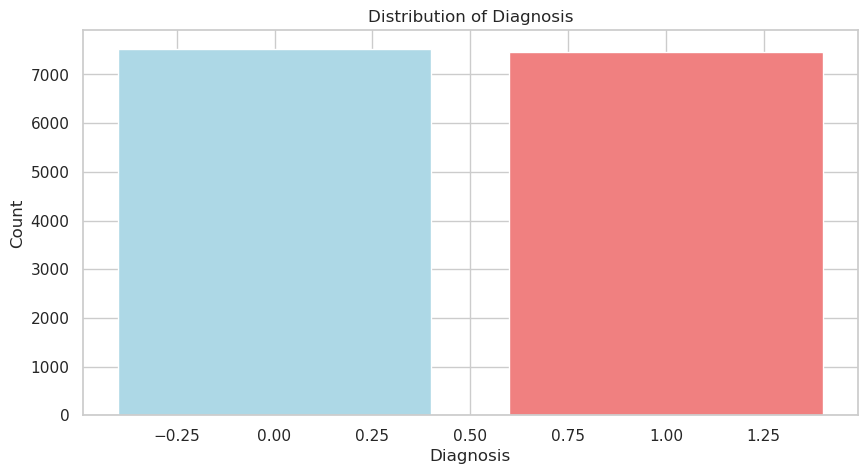

In [63]:
# Visualizing the data balance of the target variable - 'Diagnosis'

label = data['Diagnosis'].value_counts().index
values = data['Diagnosis'].value_counts().values

# Bar Chart

plt.figure(figsize=(10, 5))
plt.bar(label, values, color=["lightblue", "lightcoral"])
plt.title("Distribution of Diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()

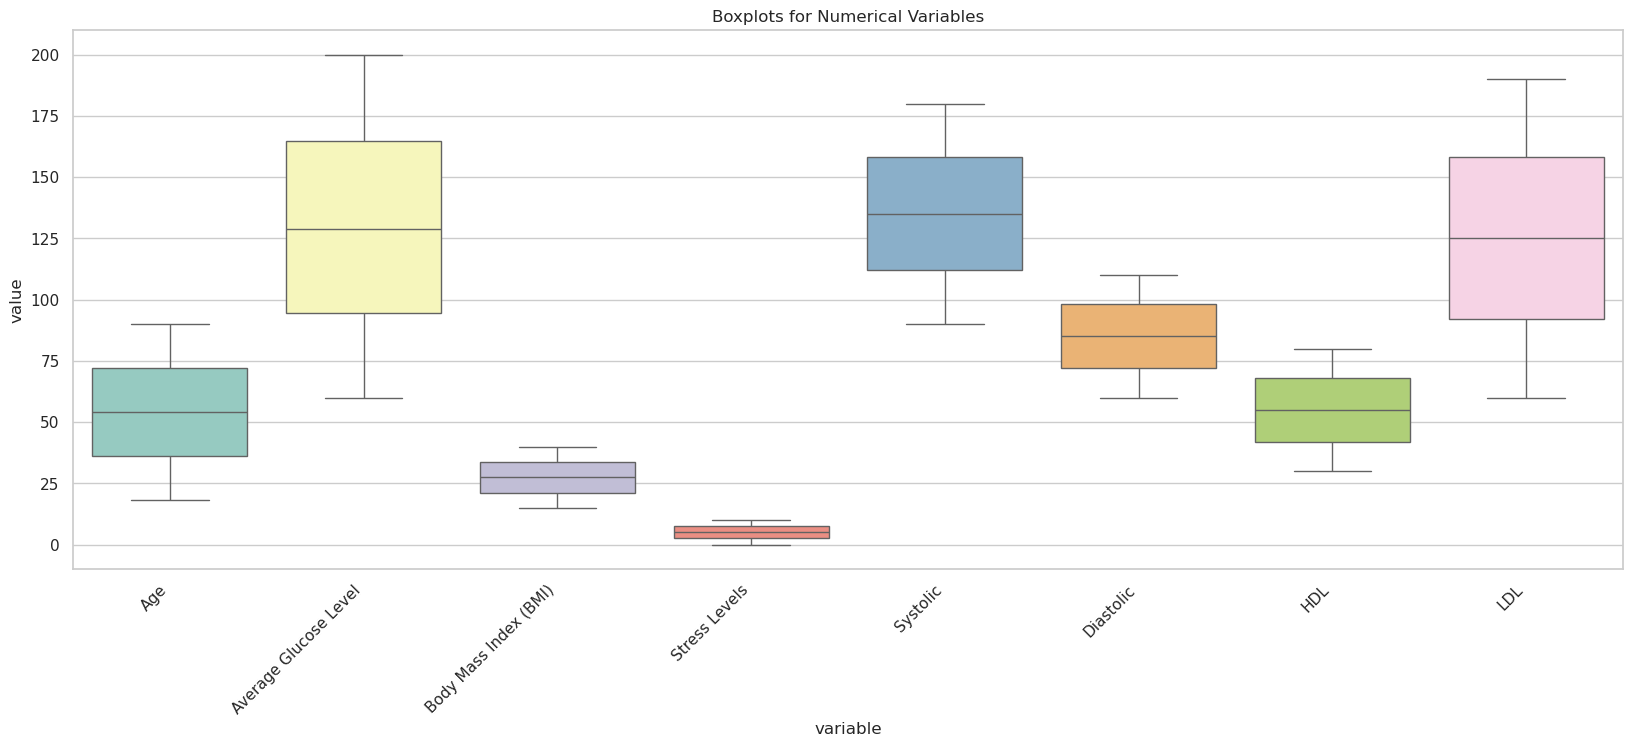

In [73]:
# Checking the Ranges of the predictor variables and dependent variable
melted_data = pd.melt(data, value_vars=numerical_columns)

# Create separate boxplots for each numerical variable
plt.figure(figsize=(20, 7))
sns.boxplot(x='variable', y='value', data=melted_data, hue='variable', palette='Set3', legend=False)
plt.title('Boxplots for Numerical Variables')
plt.xticks(rotation=45, ha='right')
plt.show()

In [74]:
# Creating a copy of the dataset before transformation
data_without_outliers = data.copy()

data_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       15000 non-null  int64  
 1   Gender                    15000 non-null  object 
 2   Hypertension              15000 non-null  int64  
 3   Heart Disease             15000 non-null  int64  
 4   Marital Status            15000 non-null  object 
 5   Work Type                 15000 non-null  object 
 6   Residence Type            15000 non-null  object 
 7   Average Glucose Level     15000 non-null  float64
 8   Body Mass Index (BMI)     15000 non-null  float64
 9   Smoking Status            15000 non-null  object 
 10  Alcohol Intake            15000 non-null  object 
 11  Physical Activity         15000 non-null  object 
 12  Stroke History            15000 non-null  int64  
 13  Family History of Stroke  15000 non-null  object 
 14  Dietar

In [75]:
# Label Encoding for Categorical Variables on Data
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

categorical_columns = ['Gender', 'Hypertension', 'Heart Disease', 'Marital Status', 'Work Type', 'Residence Type', 'Smoking Status', 'Alcohol Intake', 'Physical Activity', 'Stroke History', 'Family History of Stroke', 'Dietary Habits', 'Symptoms']

for column in categorical_columns:
    data[column] = labelencoder.fit_transform(data[column])

data.head(10)

,Age,Gender,Hypertension,Heart Disease,Marital Status,Work Type,Residence Type,Average Glucose Level,Body Mass Index (BMI),Smoking Status,...,Stroke History,Family History of Stroke,Dietary Habits,Stress Levels,Symptoms,Diagnosis,Systolic,Diastolic,HDL,LDL
0,56,1,0,1,1,3,0,130.91,22.37,2,...,0,1,5,3.48,1375,1,140,108,68,133
1,80,1,0,0,2,3,1,183.73,32.57,2,...,0,0,3,1.73,3146,1,146,91,63,70
2,26,1,1,1,1,1,0,189.00,20.32,1,...,0,1,3,7.31,4201,1,154,97,59,95
3,73,1,0,0,1,1,1,185.29,27.50,2,...,0,0,3,5.35,4059,0,174,81,70,137
4,51,1,1,1,0,3,1,177.34,29.06,0,...,0,1,4,6.84,1150,1,121,95,65,68
5,62,0,0,0,2,2,1,91.60,37.47,0,...,0,0,0,4.85,4637,1,132,64,80,69
6,40,0,1,0,1,2,1,77.83,28.20,0,...,1,0,6,6.38,1150,0,178,105,31,134
7,61,0,0,1,0,0,0,194.73,26.44,1,...,1,0,5,5.85,2911,1,179,72,66,134
8,72,0,1,1,1,3,0,72.99,30.10,1,...,1,0,6,0.73,3075,1,141,106,71,140
9,82,1,0,0,0,3,1,111.23,28.83,0,...,1,1,2,8.39,1150,0,119,88,32,88


Gender
1    3799
0    3669
Name: count, dtype: int64


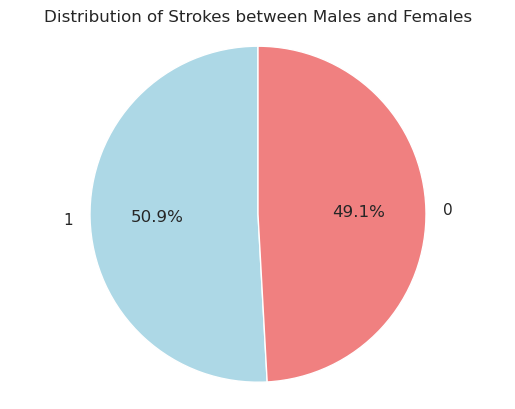

In [76]:
# Processed dataset copy
dataframe = data

# Data Analysis based on Gender
stroke_counts = dataframe[dataframe['Diagnosis'] == 1]['Gender'].value_counts()

print(stroke_counts)

# Creating a pie chart depicting distribution of stroke based on gender
plt.pie(stroke_counts, labels=stroke_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.axis('equal')
plt.title('Distribution of Strokes between Males and Females')
plt.savefig("1.png")
plt.show()

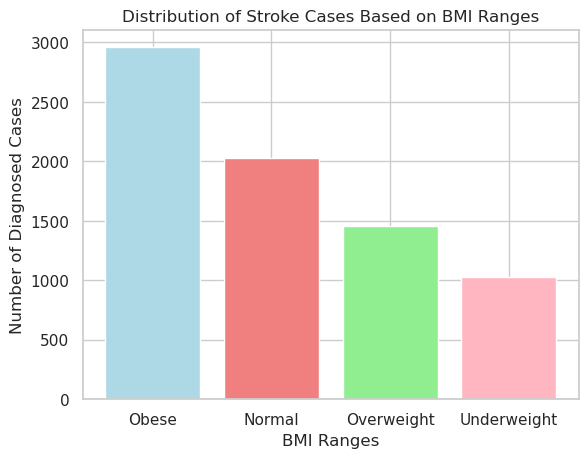

In [77]:
# Data Analysis based on Body Mass Index
# Create custom BMI ranges
bins = [0, 18.5, 24.9, 29.9, float('inf')]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']

# Use pd.cut within the plotting code to categorize BMI values
dataframe['BMI Range'] = pd.cut(dataframe['Body Mass Index (BMI)'], bins=bins, labels=labels, include_lowest=True)

# Count the number of strokes for each BMI range
stroke_counts = dataframe[dataframe['Diagnosis'] == 1]['BMI Range'].value_counts()

# Creating a bar plot depicting distribution of stroke based on BMI ranges
plt.bar(stroke_counts.index, stroke_counts, color=['lightblue', 'lightcoral', 'lightgreen', 'lightpink'])
plt.title('Distribution of Stroke Cases Based on BMI Ranges')
plt.xlabel('BMI Ranges')
plt.ylabel('Number of Diagnosed Cases')
plt.savefig('stroke_distribution_bmi.png')
plt.show()

# Remove the temporary 'BMI Range' column
dataframe.drop('BMI Range', axis=1, inplace=True)

<Axes: >

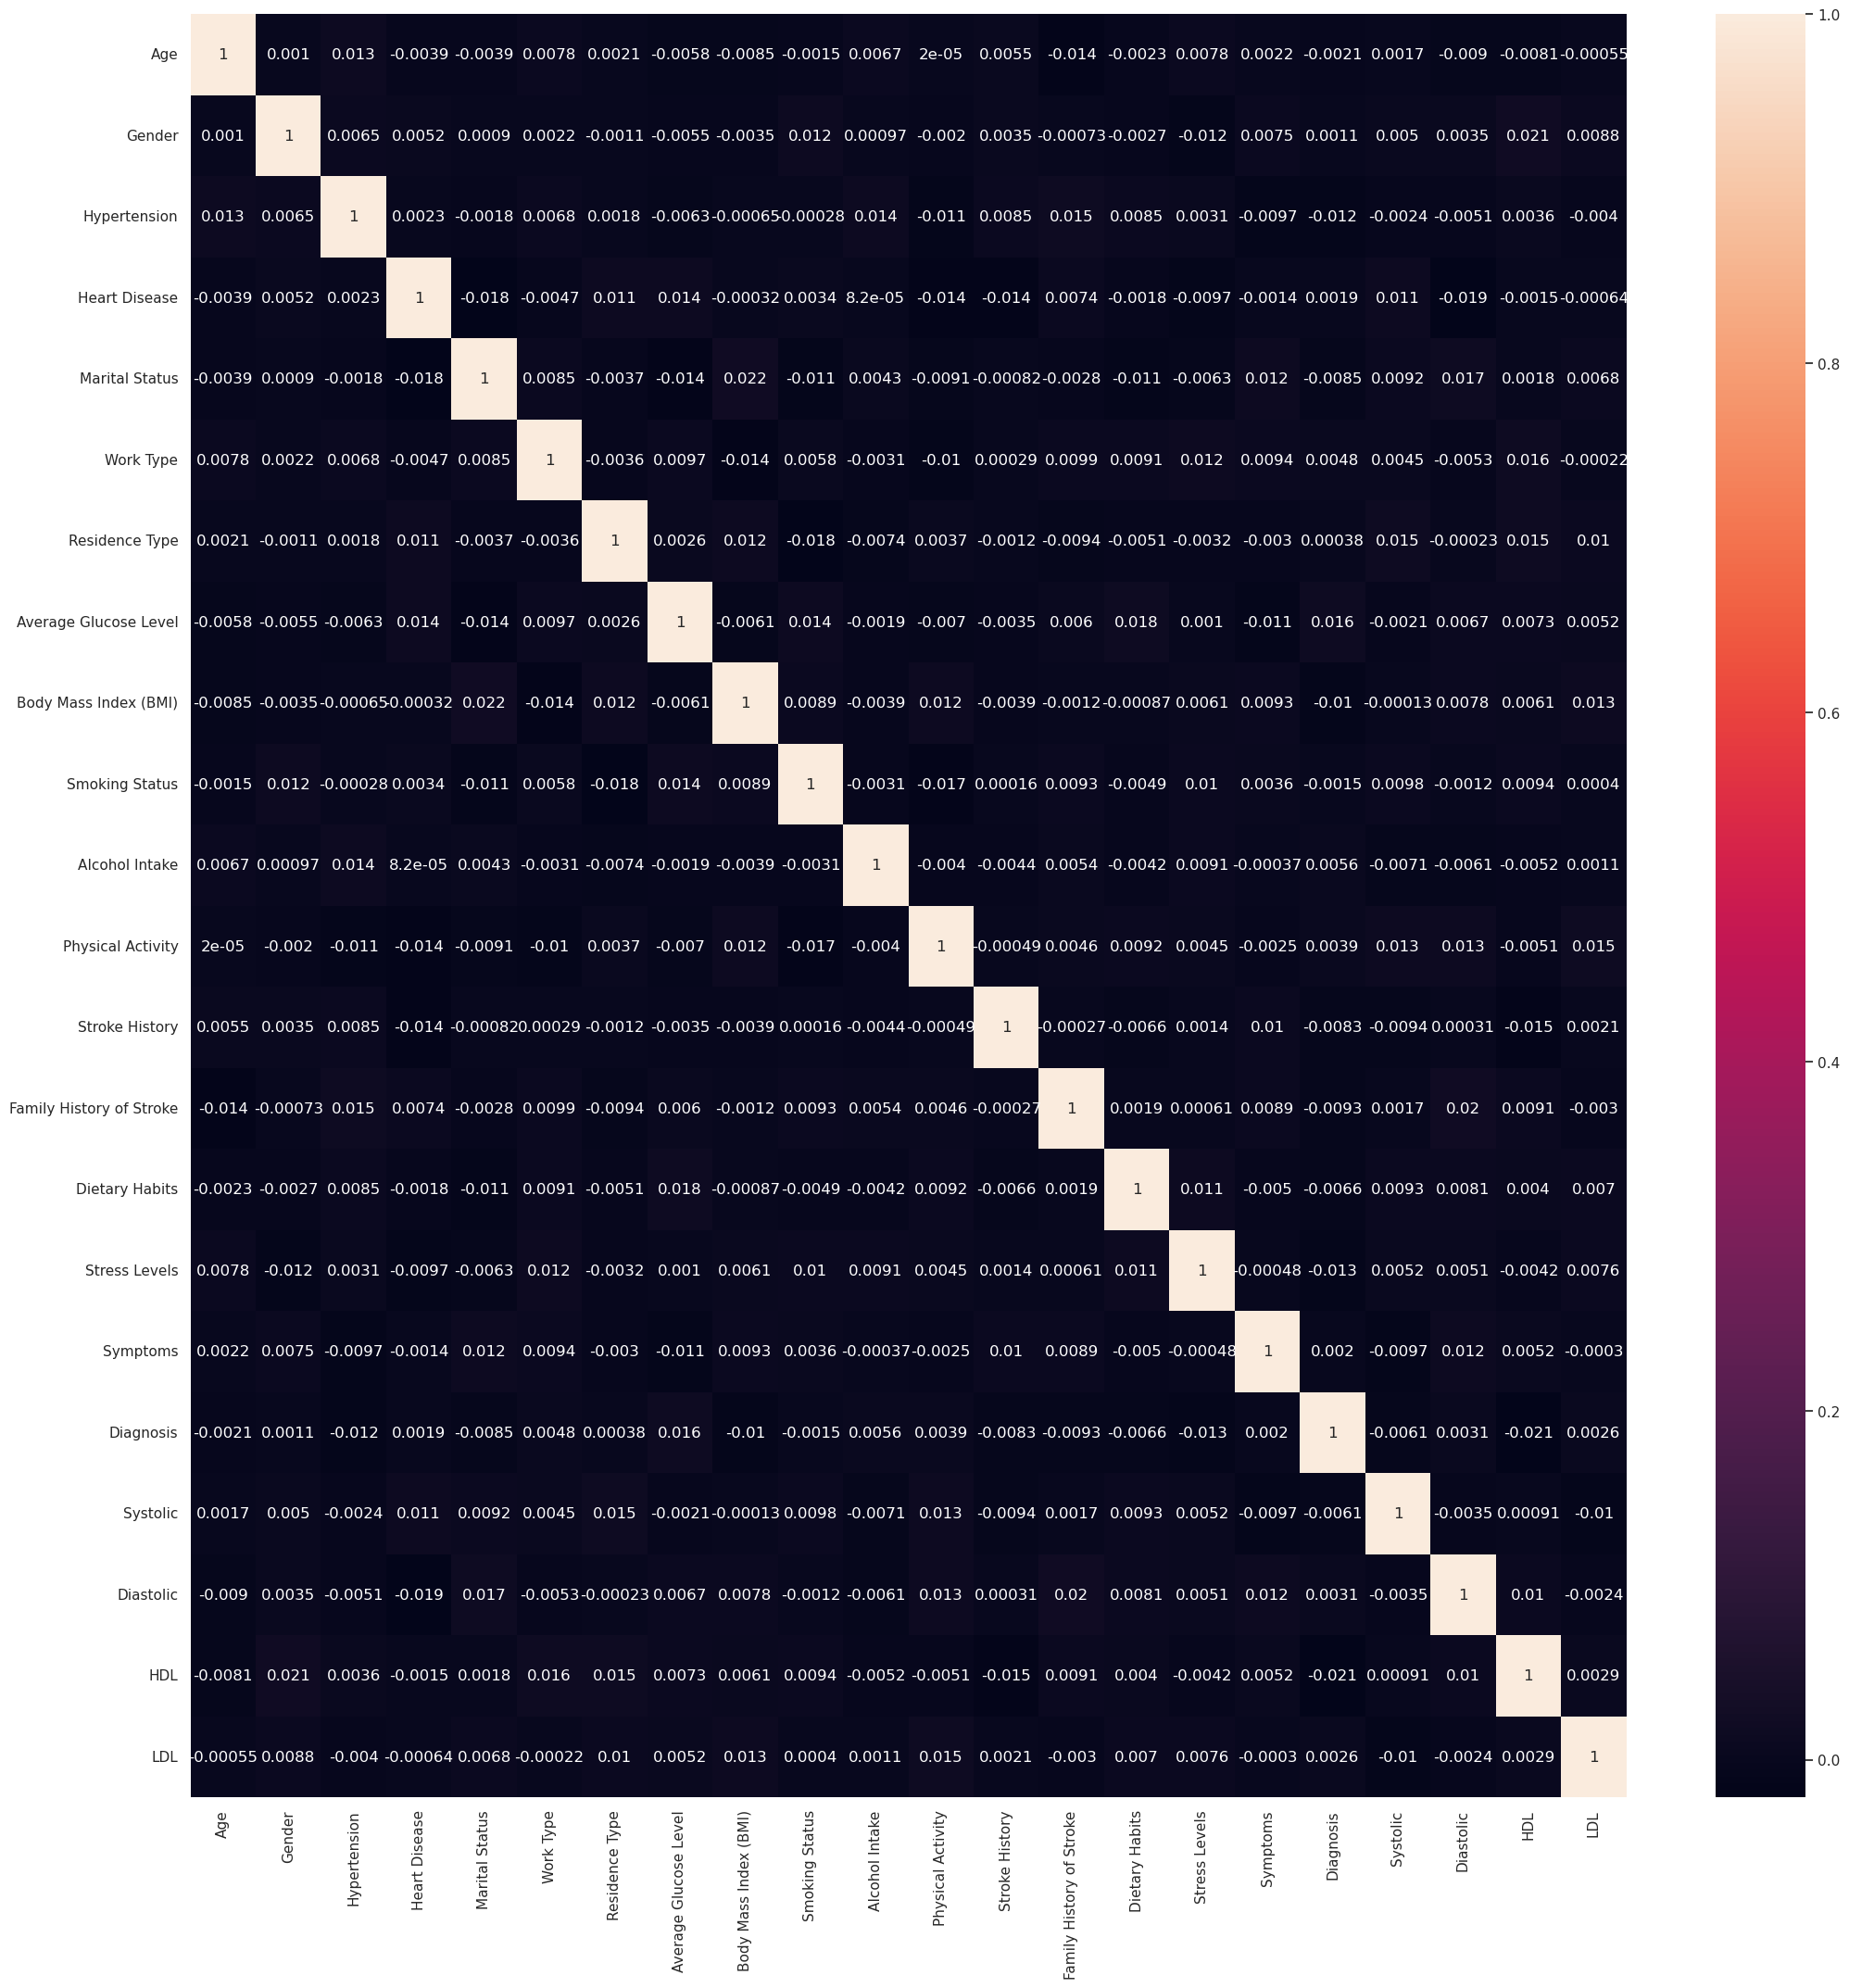

In [79]:
# Create the heat map of the correlation
plt.figure(figsize=(25, 25))
sns.heatmap(dataframe.corr(), annot=True)

# ***5. Modeling***

Training and Testing within SageMaker

In [82]:
from sklearn.model_selection import train_test_split

# DataFrame with features X and target variable y
X = dataframe.drop('Diagnosis', axis=1)
y = dataframe['Diagnosis']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [85]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [86]:
# Prepare the training and testing data
train_data = pd.concat([y_train_smote, X_train_smote], axis=1)
test_data = pd.concat([y_test, X_test], axis=1)

In [87]:
train_file = 'train.csv'
test_file = 'test.csv'

In [88]:
train_data.to_csv(train_file, index=False, header=False)
test_data.to_csv(test_file, index=False, header=False)

In [89]:
# Upload the data to S3
s3_bucket = sagemaker_session.default_bucket()
s3_prefix = 'stroke-prediction-xgboost'

In [90]:
train_s3_path = sagemaker_session.upload_data(train_file, bucket=s3_bucket, key_prefix=f"{s3_prefix}/train")
test_s3_path = sagemaker_session.upload_data(test_file, bucket=s3_bucket, key_prefix=f"{s3_prefix}/test")

In [91]:
# Get the XGBoost container image URI
xgboost_container = sagemaker.image_uris.retrieve('xgboost', region, version='latest')

In [92]:
# Define the XGBoost model
xgb = Estimator(
    image_uri=xgboost_container,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path=f"s3://{s3_bucket}/{s3_prefix}/output",
    sagemaker_session=sagemaker_session
)

In [93]:
xgb.set_hyperparameters(
    objective='binary:logistic',
    num_round=100, 
    max_depth=5,   
    eta=0.3,       
    eval_metric='logloss' 
)

In [94]:
# Define the data inputs
train_input = TrainingInput(s3_data=train_s3_path, content_type='csv')
test_input = TrainingInput(s3_data=test_s3_path, content_type='csv')

In [95]:
# Train the model
xgb.fit({'train': train_input, 'validation': test_input})

INFO:sagemaker:Creating training-job with name: xgboost-2024-08-11-23-41-41-497


2024-08-11 23:41:41 Starting - Starting the training job...
2024-08-11 23:41:58 Starting - Preparing the instances for training...
2024-08-11 23:42:19 Downloading - Downloading input data...
2024-08-11 23:42:54 Downloading - Downloading the training image...
2024-08-11 23:43:40 Training - Training image download completed. Training in progress...Arguments: train
[2024-08-11:23:43:52:INFO] Running standalone xgboost training.
[2024-08-11:23:43:52:INFO] File size need to be processed in the node: 0.94mb. Available memory size in the node: 8464.25mb
[2024-08-11:23:43:52:INFO] Determined delimiter of CSV input is ','
[23:43:52] S3DistributionType set as FullyReplicated
[23:43:52] 7580x21 matrix with 159180 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2024-08-11:23:43:52:INFO] Determined delimiter of CSV input is ','
[23:43:52] S3DistributionType set as FullyReplicated
[23:43:52] 7500x21 matrix with 157500 entries loaded from /opt/ml/input/data/validat

# ***6. Deploy the trained model as Endpoint***

* Once deployed, Test the endpoint with real time data

In [99]:
# Deploy the model
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2024-08-11-23-52-29-777
INFO:sagemaker:Creating endpoint-config with name xgboost-2024-08-11-23-52-29-777
INFO:sagemaker:Creating endpoint with name xgboost-2024-08-11-23-52-29-777


------!

In [100]:
# Set the serializer and deserializer for the predictor
xgb_predictor.serializer = CSVSerializer()
xgb_predictor.deserializer = JSONDeserializer()

In [101]:
# Make predictions on the test set
y_pred = []
for index, row in X_test.iterrows():
    result = xgb_predictor.predict(row.values)
    y_pred.append(result)

# Convert predictions to binary outcomes
y_pred = np.round(y_pred)

In [102]:
# Evaluate the model
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 49.72%


# ***7. Visualizing Results***

* Confusion matrix
* ROC Curve

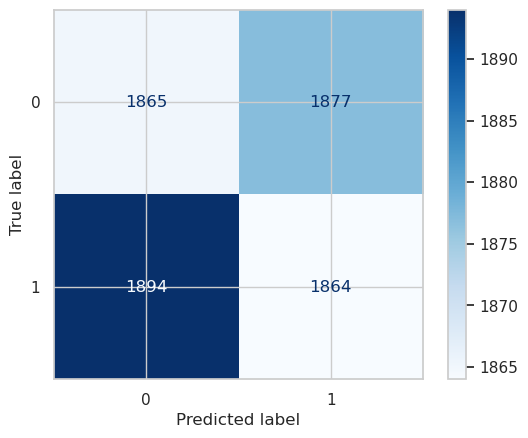

In [103]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [105]:
# Generate predicted probabilities for the positive class
y_pred_proba = []
for index, row in X_test.iterrows():
    result = xgb_predictor.predict(row.values)
    y_pred_proba.append(float(result))  # Directly append the float result

# Convert the list to a numpy array
y_pred_proba = np.array(y_pred_proba)


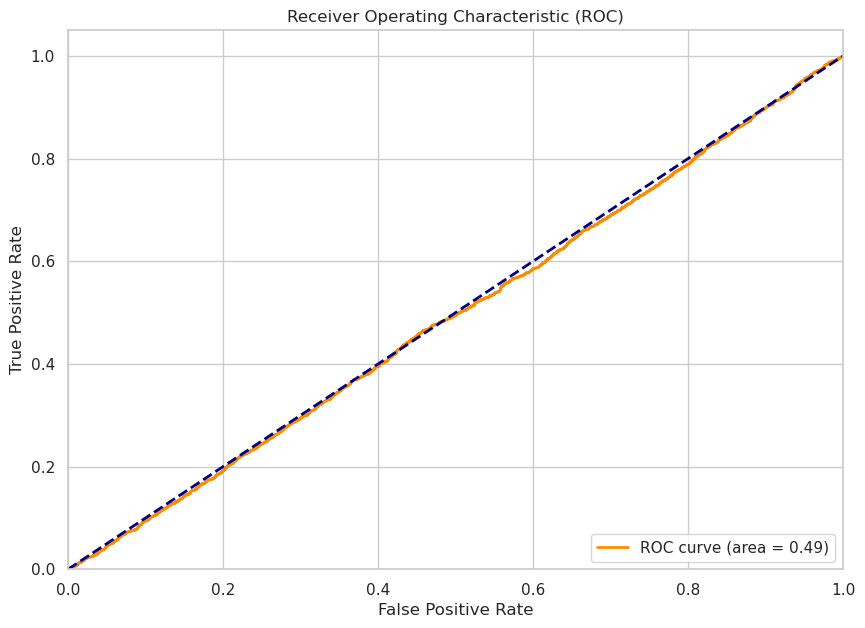

AUC: 0.49


In [106]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Assuming `y_test` is the true labels and `y_pred_proba` are the predicted probabilities

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print AUC score
print(f'AUC: {roc_auc_score(y_test, y_pred_proba):.2f}')


# ***8. Testing model***

* Sample Input
* Stroke Prediction
* SageMaker Endpoint Testing
* Bedrock Model testing

In [107]:
# Select a few rows from the test set
sample_data = X_test.head(5)  # Adjust the number of rows as needed

# Convert to CSV format without headers and index
sample_csv = sample_data.to_csv(index=False, header=False)

# Print the CSV format
print(sample_csv)


71,1,1,1,1,0,1,140.46,36.58,0,3,0,0,1,3,4.06,4699,134,76,40,104
34,1,0,0,1,1,0,71.0,32.52,2,0,1,1,1,6,3.75,1150,137,102,54,109
90,0,0,1,0,1,1,196.55,17.62,2,1,1,0,0,4,5.56,566,125,88,56,164
30,0,0,0,2,0,1,182.13,21.05,1,3,2,0,1,2,4.16,78,107,89,77,80
82,1,0,0,1,1,1,103.33,35.88,0,1,1,0,1,5,5.31,3683,171,74,67,73



In [109]:

# Example input data for prediction
input_data = {
    'Age': 25,
    'Gender': 1,
    'Hypertension': 0,
    'Heart Disease': 0,
    'Marital Status': 1,
    'Work Type': 2,
    'Residence Type': 1,
    'Average Glucose Level': 85,
    'Body Mass Index (BMI)': 22,
    'Smoking Status': 0,
    'Alcohol Intake': 0,
    'Physical Activity': 0,
    'Stroke History': 0,
    'Family History of Stroke': 0,
    'Dietary Habits': 0,
    'Stress Levels': 80.0,
    'Systolic': 140,
    'Diastolic': 90,
    'HDL': 60,
    'LDL': 100
}

# Convert input data to a DataFrame and then to CSV format
input_df = pd.DataFrame([input_data])
input_csv = input_df.to_csv(index=False, header=False)

# Initialize the predictor
xgb_predictor = Predictor(
    endpoint_name='xgboost-2024-08-11-23-52-29-777',
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer()
)

# Predict using the endpoint
result = xgb_predictor.predict(input_csv)
probability_score = float(result)

# Convert the probability score to a binary outcome
threshold = 0.5
prediction = "Stroke" if probability_score >= threshold else "No Stroke"

# print(f'Probability Score: {probability_score}')
print(f'Prediction: {prediction}')


Prediction: No Stroke


In [112]:
import boto3
import json
import requests
from botocore.auth import SigV4Auth
from botocore.awsrequest import AWSRequest
from botocore.credentials import Credentials
from botocore.session import get_session

# Initialize the Bedrock runtime client
client = boto3.client('bedrock-runtime', region_name='us-west-2')

# Define the input data
prediction_data = {
    "Age": 67,
    "Gender": "Male",
    "Hypertension": "No",
    "Heart Disease": "No",
    "Marital Status": "Married",
    "Work Type": 2,
    "Residence Type": "Urban",
    "Average Glucose Level": 228.69,
    "Body Mass Index (BMI)": 36.6,
    "Smoking Status": 5,
    "Alcohol Intake": "Yes",
    "Physical Activity": "Inactive",
    "Stroke History": "No",
    "Family History of Stroke": "No",
    "Dietary Habits": "Unhealthy",
    "Stress Levels": 80.0,
    "Systolic": 140,
    "Diastolic": 90,
    "HDL": 60,
    "LDL": 100,
    "Stroke Risk": 0.4084714651107788
}

# Create the prompt
prompt = (
    f"Age: {prediction_data['Age']}, Gender: {prediction_data['Gender']}, Hypertension: {prediction_data['Hypertension']}, "
    f"Heart Disease: {prediction_data['Heart Disease']}, Marital Status: {prediction_data['Marital Status']}, "
    f"Work Type: {prediction_data['Work Type']}, Residence Type: {prediction_data['Residence Type']}, "
    f"Average Glucose Level: {prediction_data['Average Glucose Level']}, Body Mass Index (BMI): {prediction_data['Body Mass Index (BMI)']}, "
    f"Smoking Status: {prediction_data['Smoking Status']}, Alcohol Intake: {prediction_data['Alcohol Intake']}, "
    f"Physical Activity: {prediction_data['Physical Activity']}, Stroke History: {prediction_data['Stroke History']}, "
    f"Family History of Stroke: {prediction_data['Family History of Stroke']}, Dietary Habits: {prediction_data['Dietary Habits']}, "
    f"Stress Levels: {prediction_data['Stress Levels']}, Systolic: {prediction_data['Systolic']}, Diastolic: {prediction_data['Diastolic']}, "
    f"HDL: {prediction_data['HDL']}, LDL: {prediction_data['LDL']}. "
    f"This is a person’s details, I need to check if the person is at risk of stroke or not?"
)

# Function to call Bedrock custom model to generate report
def generate_report(prompt, model_id):
    # Prepare the request payload
    payload = {
        "inputText": prompt,
        "textGenerationConfig": {
            "maxTokenCount": 512,
            "temperature": 0,
            "topP": 0.9
        }
    }
    
    # Invoke the model
    response = client.invoke_model(
        accept='application/json',
        contentType='application/json',
        body=json.dumps(payload),
        modelId=model_id
    )
    
    # Convert streaming body to byte and then byte to string
    response_byte = response['body'].read()
    response_string = response_byte.decode('utf-8')
    
    return json.loads(response_string)

# Test the function directly in Jupyter notebook
model_id = 'arn:aws:bedrock:us-west-2:533267211033:provisioned-model/19x5a29wnwbx' 
try:
    generated_report = generate_report(prompt, model_id)
    print("Generated Report:")
    print(json.dumps(generated_report, indent=2))
except Exception as e:
    print(f"Error generating report from Bedrock: {str(e)}")


Generated Report:
{
  "inputTextTokenCount": 165,
  "results": [
    {
      "tokenCount": 16,
      "outputText": "\nBased on the provided content, the person is at risk of stroke.",
      "completionReason": "FINISH"
    }
  ]
}


# ***9. Tranform data according to Bedrock requirements***

* Dataset used for sageMaker model should be used in Bedrock.
* And Bedrock required input data to be in JSON Format.

In [ ]:
import boto3
import csv
import json
import os

# Initialize the S3 client
s3 = boto3.client('s3')

# Define the S3 bucket and file key
bucket_name = 'x22239243-spm'
csv_key = 'stroke_prediction_dataset.csv'
jsonl_key = 'stroke_prediction_dataset.jsonl'

# Temporary local file paths
local_csv_path = '/tmp/stroke_prediction_dataset.csv'
local_jsonl_path = '/tmp/stroke_prediction_dataset.jsonl'

# Download the CSV file from S3
try:
    s3.download_file(bucket_name, csv_key, local_csv_path)
    print("CSV file downloaded successfully")
except Exception as e:
    print("Error downloading CSV file:", e)
    raise

# Convert the CSV file to JSONL format with only 'input' key
try:
    with open(local_csv_path, mode='r', encoding='utf-8-sig') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        with open(local_jsonl_path, mode='w', encoding='utf-8') as jsonl_file:
            for row in csv_reader:
                # Only include the 'input' key in the JSON object
                json_line = json.dumps({"input": row})
                jsonl_file.write(json_line + '\n')
    print("CSV file converted to JSONL successfully")
except Exception as e:
    print("Error converting CSV to JSONL:", e)
    raise

# Verify JSONL file format
try:
    with open(local_jsonl_path, 'r', encoding='utf-8') as jsonl_file:
        for line in jsonl_file:
            json.loads(line)  # This will raise an error if the line is not valid JSON
    print("JSONL file format verified successfully")
except Exception as e:
    print("Error in JSONL file format:", e)
    raise

# Upload the JSONL file back to S3
try:
    s3.upload_file(local_jsonl_path, bucket_name, jsonl_key)
    print("JSONL file uploaded successfully")
except Exception as e:
    print("Error uploading JSONL file:", e)
    raise

# Clean up temporary local files
try:
    os.remove(local_csv_path)
    os.remove(local_jsonl_path)
    print("Temporary files cleaned up")
except Exception as e:
    print("Error cleaning up temporary files:", e)
